In [170]:
%load_ext line_profiler

import os, datetime
from gensim.models import KeyedVectors
from pandas import read_csv
import pandas
import numpy as np
from nltk.tokenize import RegexpTokenizer

import scipy
from scipy.spatial.distance import cosine
from scipy.spatial import KDTree
from scipy.stats import spearmanr

from sklearn.model_selection import KFold, GroupKFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.pipeline import Pipeline

import torch
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F
import skorch

import matplotlib.pyplot as plt
import seaborn as sns

alpha_tokenizer = RegexpTokenizer('[А-Яа-яA-Za-z]\w+')

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


# Load data

### Extrinsic

In [3]:
good_essays = read_csv('../../plag/essays/good_essays_FORMATTED.csv')[['original_sentence', 'modified_sentence']].dropna().reset_index(drop=True)
all_essays = read_csv('../../plag/essays/all_essays_FORMATTED.csv')[['original_sentence', 'modified_sentence']].dropna().reset_index(drop=True)

In [4]:
paraphrases = read_csv('../../plag/cross-lang-paraphrase-with-docs.csv').sample(frac=1).reset_index(drop=True)
strict_train_test_data = [(paraphrases.iloc[train_idx], paraphrases.iloc[test_idx]) for train_idx, test_idx in
                          GroupKFold(n_splits=3).split(paraphrases, paraphrases.is_paraphrase.values, paraphrases.document.values)]
mixed_train_test_data = [(paraphrases.iloc[train_idx], paraphrases.iloc[test_idx]) for train_idx, test_idx in
                         KFold(n_splits=3, shuffle=True).split(paraphrases, paraphrases.is_paraphrase.values)]

In [84]:
yandex = read_csv('../../corpora/parallel/yandex/yandex_with_negative_sim.csv', index_col=0).sample(frac=1).reset_index(drop=True)
yandex_train_test_data = [(yandex.iloc[train_idx], yandex.iloc[test_idx]) for train_idx, test_idx in
                          KFold(n_splits=3).split(yandex, yandex.is_paraphrase.values)]

/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [85]:
EXTRINSIC_DATASETS = (
    ('para strict', strict_train_test_data),
#     ('para mixed', mixed_train_test_data),
    ('yandex wmt', yandex_train_test_data),
)

In [7]:
en_ru_dict = {}

with open('../../word-benchmarks/intrinsic/dictionary/en-ru.txt', 'r') as f:
    for word_pair in f.read().split('\n')[:-1]:
        en_ru_dict[word_pair.split(' ')[0]] = word_pair.split(' ')[1]

### Intrinsic

In [8]:
english_russian_word_similarity = [
                ('../../word-benchmarks/intrinsic/word-similarity/cross-lingual/en-ru/simverb-3500.csv', 'SimVerb-3074'),
                ('../../word-benchmarks/men.csv', 'MEN-1146'),
                ('../../word-benchmarks/intrinsic/word-similarity/cross-lingual/en-ru/rw.csv', 'RareWord-968'),
                ('../../word-benchmarks/intrinsic/word-similarity/cross-lingual/en-ru/simlex999.csv', 'SimLex-739'),
                ('../../word-benchmarks/intrinsic/word-similarity/cross-lingual/en-ru/mturk-771.csv', 'MTurk-551'),
                ('../../word-benchmarks/intrinsic/word-similarity/cross-lingual/en-ru/semeval-2017.csv', 'SemEval-243'),
                ('../../word-benchmarks/intrinsic/word-similarity/cross-lingual/en-ru/wordsim353-rel.csv', 'WordRel-193'),
                ('../../word-benchmarks/intrinsic/word-similarity/cross-lingual/en-ru/wordsim353-sim.csv', 'WordSim-193'),
                ('../../word-benchmarks/intrinsic/word-similarity/cross-lingual/en-ru/verb-143.csv', 'Verb-115'),
                ('../../word-benchmarks/intrinsic/word-similarity/cross-lingual/en-ru/yp-130.csv', 'YP-111'),
                ('../../word-benchmarks/rg-65.csv', 'RG-54'),
                ('../../word-benchmarks/mc-30.csv', 'MC-28'),
                ]

### Models

In [9]:
def convert_keyed_vectors_if_not_exists(src_path, target_path):
    if os.path.exists(target_path):
        return
    model = KeyedVectors.load_word2vec_format(src_path)
    model.save(target_path)

Vecmap

In [10]:
convert_keyed_vectors_if_not_exists('../cross-lang/MODELS/vecmap/en.vec', '../cross-lang/MODELS/vecmap/en.gensim')
convert_keyed_vectors_if_not_exists('../cross-lang/MODELS/vecmap/ru.vec', '../cross-lang/MODELS/vecmap/ru.gensim')
vecmap_en = KeyedVectors.load('../cross-lang/MODELS/vecmap/en.gensim', mmap='r')
vecmap_ru = KeyedVectors.load('../cross-lang/MODELS/vecmap/ru.gensim', mmap='r')

MUSE supervised

In [11]:
convert_keyed_vectors_if_not_exists('../cross-lang/MODELS/muse_supervised/2db0qcgzth/vectors-en.txt', '../cross-lang/MODELS/muse_supervised/2db0qcgzth/vectors-en.gensim')
convert_keyed_vectors_if_not_exists('../cross-lang/MODELS/muse_supervised/2db0qcgzth/vectors-ru.txt', '../cross-lang/MODELS/muse_supervised/2db0qcgzth/vectors-ru.gensim')
muse_s_en = KeyedVectors.load('../cross-lang/MODELS/muse_supervised/2db0qcgzth/vectors-en.gensim', mmap='r')
muse_s_ru = KeyedVectors.load('../cross-lang/MODELS/muse_supervised/2db0qcgzth/vectors-ru.gensim', mmap='r')

MUSE unsupervised

In [12]:
convert_keyed_vectors_if_not_exists('../cross-lang/MODELS/muse_unsupervised/vectors-en.txt', '../cross-lang/MODELS/muse_unsupervised/vectors-en.gensim')
convert_keyed_vectors_if_not_exists('../cross-lang/MODELS/muse_unsupervised/vectors-ru.txt', '../cross-lang/MODELS/muse_unsupervised/vectors-ru.gensim')
muse_u_en = KeyedVectors.load('../cross-lang/MODELS/muse_unsupervised/vectors-en.gensim', mmap='r')
muse_u_ru = KeyedVectors.load('../cross-lang/MODELS/muse_unsupervised/vectors-ru.gensim', mmap='r')

Bilingual CCA

In [13]:
convert_keyed_vectors_if_not_exists('../cross-lang/MODELS/BiCCA/wiki.en.vec.ccaed.vec', '../cross-lang/MODELS/BiCCA/wiki.en.vec.ccaed.gensim')
convert_keyed_vectors_if_not_exists('../cross-lang/MODELS/BiCCA/wiki.ru.vec.ccaed.vec', '../cross-lang/MODELS/BiCCA/wiki.ru.vec.ccaed.gensim')
bi_cca_en = KeyedVectors.load('../cross-lang/MODELS/BiCCA/wiki.en.vec.ccaed.gensim', mmap='r')
bi_cca_ru = KeyedVectors.load('../cross-lang/MODELS/BiCCA/wiki.ru.vec.ccaed.gensim', mmap='r')

MultiFastText

In [14]:
convert_keyed_vectors_if_not_exists('../cross-lang/MODELS/MFT/mft-en.vec', '../cross-lang/MODELS/MFT/mft-en.gensim')
convert_keyed_vectors_if_not_exists('../cross-lang/MODELS/MFT/mft-ru.vec', '../cross-lang/MODELS/MFT/mft-ru.gensim')
mft_en = KeyedVectors.load('../cross-lang/MODELS/MFT/mft-en.gensim', mmap='r')
mft_ru = KeyedVectors.load('../cross-lang/MODELS/MFT/mft-ru.gensim', mmap='r')

In [15]:
# mft_en.vector_size = mft_en.n_dim
# mft_ru.vector_size = mft_ru.n_dim

In [16]:
models = [(vecmap_en, vecmap_ru, 'Vecmap'),
         (muse_s_en, muse_s_ru, 'MSE'),
         (muse_u_en, muse_u_ru, 'MUE'),
         (bi_cca_en, bi_cca_ru, 'BiCCA'),
         (mft_en, mft_ru, 'MFT')]

# Calculate intrinsic scores

### Functions

In [17]:
def get_word_vector(word, model, vector_size=300):
    if len(word.split(' ')) == 1:
        return model[word]
    else:
        vector = np.zeros(shape=model.vector_size)
        for subword in word.split(' '):
            vector = np.add(vector, model[subword])
        return vector / len(word.split(' '))

In [18]:
def calculate_cosines(dataset, src_embeddings, trg_embeddings, verbose=True):
    dataset_len = len(dataset)
    vector_sims = []
    human_sims = []
    for i, m in dataset.iterrows():
        try:
            vector_sims.append(1 - cosine(get_word_vector(m['word1'].lower(), src_embeddings),
                                          get_word_vector(m['word2'].lower(), trg_embeddings)))
            human_sims.append(m['similarity'])
        except KeyError:
            continue
    if verbose:
        print('Percent of dropped = {:2.1f}%, amount of remanining words = {}'.format((dataset_len - len(human_sims))/dataset_len*100, len(human_sims)))
    return np.array(vector_sims), np.array(human_sims)

### Result

In [19]:
for dataset, name in english_russian_word_similarity:
    print('{}: Correlation with Russian human judgements of English word2vec vectors: {:0.2f} ({:0.2f})'.format(name ,*spearmanr(*calculate_cosines(read_csv(dataset), vecmap_en, vecmap_ru))))

Percent of dropped = 1.3%, amount of remanining words = 3455
SimVerb-3074: Correlation with Russian human judgements of English word2vec vectors: 0.23 (0.00)
Percent of dropped = 0.3%, amount of remanining words = 2990
MEN-1146: Correlation with Russian human judgements of English word2vec vectors: 0.69 (0.00)
Percent of dropped = 5.1%, amount of remanining words = 1931
RareWord-968: Correlation with Russian human judgements of English word2vec vectors: 0.43 (0.00)
Percent of dropped = 0.5%, amount of remanining words = 994
SimLex-739: Correlation with Russian human judgements of English word2vec vectors: 0.35 (0.00)
Percent of dropped = 0.6%, amount of remanining words = 766
MTurk-551: Correlation with Russian human judgements of English word2vec vectors: 0.57 (0.00)
Percent of dropped = 3.8%, amount of remanining words = 481
SemEval-243: Correlation with Russian human judgements of English word2vec vectors: 0.61 (0.00)
Percent of dropped = 0.4%, amount of remanining words = 251
WordR

In [20]:
for dataset, name in english_russian_word_similarity:
    print('{}: Correlation with Russian human judgements of English word2vec vectors: {:0.2f} ({:0.2f})'.format(name ,*spearmanr(*calculate_cosines(read_csv(dataset), muse_s_en, muse_s_ru))))

Percent of dropped = 12.2%, amount of remanining words = 3074
SimVerb-3074: Correlation with Russian human judgements of English word2vec vectors: 0.20 (0.00)
Percent of dropped = 4.3%, amount of remanining words = 2871
MEN-1146: Correlation with Russian human judgements of English word2vec vectors: 0.68 (0.00)
Percent of dropped = 43.7%, amount of remanining words = 1146
RareWord-968: Correlation with Russian human judgements of English word2vec vectors: 0.44 (0.00)
Percent of dropped = 4.1%, amount of remanining words = 958
SimLex-739: Correlation with Russian human judgements of English word2vec vectors: 0.34 (0.00)
Percent of dropped = 4.2%, amount of remanining words = 739
MTurk-551: Correlation with Russian human judgements of English word2vec vectors: 0.56 (0.00)
Percent of dropped = 12.0%, amount of remanining words = 440
SemEval-243: Correlation with Russian human judgements of English word2vec vectors: 0.60 (0.00)
Percent of dropped = 3.6%, amount of remanining words = 243
Wo

In [21]:
for dataset, name in english_russian_word_similarity:
    print('{}: Correlation with Russian human judgements of English word2vec vectors: {:0.2f} ({:0.2f})'.format(name ,*spearmanr(*calculate_cosines(read_csv(dataset), muse_u_en, muse_u_ru))))

Percent of dropped = 12.2%, amount of remanining words = 3074
SimVerb-3074: Correlation with Russian human judgements of English word2vec vectors: 0.20 (0.00)
Percent of dropped = 4.3%, amount of remanining words = 2871
MEN-1146: Correlation with Russian human judgements of English word2vec vectors: 0.66 (0.00)
Percent of dropped = 43.7%, amount of remanining words = 1146
RareWord-968: Correlation with Russian human judgements of English word2vec vectors: 0.42 (0.00)
Percent of dropped = 4.1%, amount of remanining words = 958
SimLex-739: Correlation with Russian human judgements of English word2vec vectors: 0.32 (0.00)
Percent of dropped = 4.2%, amount of remanining words = 739
MTurk-551: Correlation with Russian human judgements of English word2vec vectors: 0.51 (0.00)
Percent of dropped = 12.0%, amount of remanining words = 440
SemEval-243: Correlation with Russian human judgements of English word2vec vectors: 0.56 (0.00)
Percent of dropped = 3.6%, amount of remanining words = 243
Wo

In [22]:
for dataset, name in english_russian_word_similarity:
    print('{}: Correlation with Russian human judgements of English word2vec vectors: {:0.2f} ({:0.2f})'.format(name ,*spearmanr(*calculate_cosines(read_csv(dataset), bi_cca_en, bi_cca_ru))))

Percent of dropped = 1.3%, amount of remanining words = 3455
SimVerb-3074: Correlation with Russian human judgements of English word2vec vectors: 0.22 (0.00)
Percent of dropped = 0.3%, amount of remanining words = 2990
MEN-1146: Correlation with Russian human judgements of English word2vec vectors: 0.66 (0.00)
Percent of dropped = 5.1%, amount of remanining words = 1931
RareWord-968: Correlation with Russian human judgements of English word2vec vectors: 0.43 (0.00)
Percent of dropped = 0.5%, amount of remanining words = 994
SimLex-739: Correlation with Russian human judgements of English word2vec vectors: 0.34 (0.00)
Percent of dropped = 0.6%, amount of remanining words = 766
MTurk-551: Correlation with Russian human judgements of English word2vec vectors: 0.54 (0.00)
Percent of dropped = 3.8%, amount of remanining words = 481
SemEval-243: Correlation with Russian human judgements of English word2vec vectors: 0.61 (0.00)
Percent of dropped = 0.4%, amount of remanining words = 251
WordR

In [23]:
for dataset, name in english_russian_word_similarity:
    print('{}: Correlation with Russian human judgements of English word2vec vectors: {:0.2f} ({:0.2f})'.format(name ,*spearmanr(*calculate_cosines(read_csv(dataset), mft_en, mft_ru))))

Percent of dropped = 1.3%, amount of remanining words = 3455
SimVerb-3074: Correlation with Russian human judgements of English word2vec vectors: 0.21 (0.00)
Percent of dropped = 0.3%, amount of remanining words = 2990
MEN-1146: Correlation with Russian human judgements of English word2vec vectors: 0.68 (0.00)
Percent of dropped = 5.1%, amount of remanining words = 1931
RareWord-968: Correlation with Russian human judgements of English word2vec vectors: 0.43 (0.00)
Percent of dropped = 0.5%, amount of remanining words = 994
SimLex-739: Correlation with Russian human judgements of English word2vec vectors: 0.34 (0.00)
Percent of dropped = 0.6%, amount of remanining words = 766
MTurk-551: Correlation with Russian human judgements of English word2vec vectors: 0.57 (0.00)
Percent of dropped = 3.8%, amount of remanining words = 481
SemEval-243: Correlation with Russian human judgements of English word2vec vectors: 0.62 (0.00)
Percent of dropped = 0.4%, amount of remanining words = 251
WordR

#### Joint table

In [24]:
intrinsic_metrics = pandas.DataFrame({ model_name : [spearmanr(*calculate_cosines(read_csv(dataset),
                                                                                  en_model,
                                                                                  ru_model,
                                                                                  verbose=False))[0]
                                                     for dataset, _ in english_russian_word_similarity]
                                      for en_model, ru_model, model_name in models},
                                     index=[name for _, name in english_russian_word_similarity]).transpose()
intrinsic_metrics

,SimVerb-3074,MEN-1146,RareWord-968,SimLex-739,MTurk-551,SemEval-243,WordRel-193,WordSim-193,Verb-115,YP-111,RG-54,MC-28
BiCCA,0.218046,0.664030,0.425192,0.341557,0.535483,0.608564,0.529424,0.669920,0.265106,0.248969,0.611195,0.720961
MFT,0.211617,0.681587,0.430048,0.336201,0.567407,0.616561,0.552381,0.705907,0.269525,0.251166,0.674324,0.696039
MSE,0.200728,0.675030,0.435278,0.344031,0.555848,0.603852,0.549236,0.689278,0.237874,0.216590,0.679475,0.674514
MUE,0.199020,0.658349,0.419917,0.315084,0.510642,0.564960,0.527156,0.669226,0.388100,0.373077,0.667048,0.704626
Vecmap,0.226787,0.690194,0.428472,0.354032,0.570920,0.614034,0.569648,0.723163,0.272304,0.250610,0.631382,0.713618


In [25]:
intrinsic_metrics_norm = (intrinsic_metrics - intrinsic_metrics.mean(0)) / intrinsic_metrics.std(0)
intrinsic_metrics_norm

,SimVerb-3074,MEN-1146,RareWord-968,SimLex-739,MTurk-551,SemEval-243,WordRel-193,WordSim-193,Verb-115,YP-111,RG-54,MC-28
BiCCA,0.581498,-0.760620,-0.453656,0.233732,-0.501510,0.330913,-0.917210,-0.924999,-0.367849,-0.316022,-1.389277,1.057550
MFT,0.032267,0.600957,0.397068,-0.137127,0.771429,0.710596,0.387008,0.617614,-0.292151,-0.279702,0.724576,-0.328937
MSE,-0.898082,0.092441,1.313112,0.405102,0.310552,0.107188,0.208338,-0.095201,-0.834276,-0.851369,0.897082,-1.526436
MUE,-1.043980,-1.201197,-1.377543,-1.599298,-1.491999,-1.739318,-1.046079,-0.954741,1.738825,1.735976,0.480946,0.148792
Vecmap,1.328297,1.268420,0.121019,1.097590,0.911527,0.590621,1.367942,1.357327,-0.244549,-0.288884,-0.713326,0.649032


In [26]:
intrinsic_metrics_order = intrinsic_metrics.apply(lambda s: s.argsort() + 1)
intrinsic_metrics_order

,SimVerb-3074,MEN-1146,RareWord-968,SimLex-739,MTurk-551,SemEval-243,WordRel-193,WordSim-193,Verb-115,YP-111,RG-54,MC-28
BiCCA,4,4,4,4,4,4,4,4,3,3,1,3
MFT,3,1,1,2,1,3,1,1,1,1,5,2
MSE,2,3,5,1,3,1,3,3,2,5,4,4
MUE,1,2,2,3,2,5,2,2,5,2,2,5
Vecmap,5,5,3,5,5,2,5,5,4,4,3,1


# Word translation

In [37]:
def evaluate_on_word_translation(model_en, model_ru, k=5):
    count = 0

    for src_word, trg_word in en_ru_dict.items():
        similar_words = model_ru.similar_by_vector(model_en[src_word], k)
        if trg_word in [word[0] for word in similar_words]:
            count += 1
    return count/len(en_ru_dict)

In [38]:
results = []

for model_en, model_ru, name in models:
    for k in [1, 5, 10]:
        results.append('{} p@{}: {}'.format(name, k, evaluate_on_word_translation(model_en, model_ru, k)))

KeyboardInterrupt: 

In [162]:
word_translation_metrics = pandas.DataFrame({'WT p@1' :  [0.32, 0.31, 0.17, 0.29, 0.21],
                                             'WT p@5' :  [0.52, 0.54, 0.35, 0.49, 0.38],
                                             'WT p@10' : [0.59, 0.61, 0.46, 0.56, 0.45],},
                                            index=['Vecmap', 'MSE', 'MUE', 'BiCCA', 'MFT'])
word_translation_metrics

,WT p@1,WT p@10,WT p@5
Vecmap,0.32,0.59,0.52
MSE,0.31,0.61,0.54
MUE,0.17,0.46,0.35
BiCCA,0.29,0.56,0.49
MFT,0.21,0.45,0.38


['Vecmap p@1: 0.32002815909890886',
 'Vecmap p@5: 0.5231725918103954',
 'Vecmap p@10: 0.5899800539716062',
 'MSE p@1: 0.3146779303062302',
 'MSE p@5: 0.5372990730963276',
 'MSE p@10: 0.6117798897101959',
 'MUE p@1: 0.16843834330634752',
 'MUE p@5: 0.34640384841018423',
 'MUE p@10: 0.42592983691188546',
 'BiCCA p@1: 0.2930658218936994',
 'BiCCA p@5: 0.49097735539129417',
 'BiCCA p@10: 0.5556728851343423']

# Calculate extrinsic scores

### Functions

In [163]:
def get_feature_vec_simple(tokens, num_features, model):
    result = np.zeros(shape=(num_features), dtype='float32')
    norm = 0
    for word in tokens:
        if word in model.wv.vocab:
            result += model[word]
            norm += 1
    if norm > 0:
        result /= norm
    return result


def get_feature_vec(tokens, num_features, model):
    token_idx = [model.vocab[w].index for w in tokens if w in model.wv.vocab]
    if len(token_idx) > 0:
        return np.mean(model.syn0[token_idx], axis=0)
    else:
        return np.zeros(num_features, dtype='float32')


def get_vectors(model_en, model_ru, dataset):
    eng_vectors = []
    rus_vectors = []
    common_vectors = []
    
    for i in dataset.index:
        eng_vec = get_feature_vec([word.lower() for word in alpha_tokenizer.tokenize(dataset.loc[i, 'sentence1'])], 
                                   model_en.vector_size, model_en)
        eng_vectors.append(eng_vec)
        rus_vec = get_feature_vec([word.lower() for word in alpha_tokenizer.tokenize(dataset.loc[i, 'sentence2'])],
                                   model_ru.vector_size, model_ru)
        rus_vectors.append(rus_vec)
        common_vectors.append(np.hstack((eng_vec, rus_vec)))
#     eng_vectors = np.array(eng_vectors)
#     rus_vectors = np.array(rus_vectors)
    return np.array(eng_vectors), np.array(rus_vectors), np.array(common_vectors)


METRICS = (
    ('f1', f1_score),
    ('p', precision_score),
    ('r', recall_score),
)

def evaluate_extrinsic(embeddings1, embeddings2, classifier_ctor, splits, metrics=METRICS, float_target=True):
    result = []
    for train_data, test_data in splits:
        _, _, X_train  = get_vectors(embeddings1, embeddings2, train_data)
        _, _, X_test  = get_vectors(embeddings1, embeddings2, test_data)
        Y_train = train_data.is_paraphrase.values
        Y_test = test_data.is_paraphrase.values
        if float_target:
            Y_train = Y_train.astype('float32')
            Y_test = Y_test.astype('float32')

        clf = classifier_ctor()
        
        clf.fit(X_train, Y_train)
        pred = np.where(clf.predict_proba(X_test) > 0.5, 1, 0)
        if pred.shape[1] > 1:
            pred = pred[:, 1]

        result.append({ metric_name : metric_func(pred, Y_test)
                       for metric_name, metric_func in metrics})
    return pandas.DataFrame(result).describe().loc[['mean', 'std']]


def vectors2cosine(vecs):
    dims = vecs.shape[1] // 2
    result = np.array([cosine(vecs[i, :dims], vecs[i, dims:]) for i in range(vecs.shape[0])])
    result[np.isnan(result)] = 1.0
    return np.expand_dims(result, 1)


def make_cosine_logreg_ctor(vector_size):
    def _f():
        return Pipeline((('cos', FunctionTransformer(vectors2cosine)),
                         ('clf', LogisticRegressionCV())))
    return _f


class BilinearModel(nn.Module):
    def __init__(self, vector_size):
        super(BilinearModel, self).__init__()
        self.vector_size = vector_size
        self.compare = nn.Bilinear(self.vector_size, self.vector_size, 1)

    def forward(self, x):
        """x.size = (Batch, Dim)"""
        a = x[:, :self.vector_size].float()
        b = x[:, self.vector_size:].float()
        return F.sigmoid(self.compare(a, b))


def make_bilinear_model_ctor(vector_size):
    def _f():
        return skorch.NeuralNet(BilinearModel,
                                module__vector_size=vector_size,
                                optimizer=torch.optim.Adam,
                                lr=0.1,
                                criterion=nn.BCELoss,
                                max_epochs=100,
                                verbose=0)
    return _f


class ProjCosineModel(nn.Module):
    def __init__(self, vector_size, proj_size=100, proj_act=lambda x: x):
        super(ProjCosineModel, self).__init__()
        self.vector_size = vector_size
        self.proj = nn.Linear(vector_size, proj_size)
        self.proj_act = proj_act
        self.out = nn.Linear(1, 1)

    def forward(self, x):
        """x.size = (Batch, Dim)"""
        a = x[:, :self.vector_size].float()
        b = x[:, self.vector_size:].float()
        ap = self.proj_act(self.proj(a))
        bp = self.proj_act(self.proj(b))
        return F.sigmoid(self.out(F.cosine_similarity(ap, bp).unsqueeze(-1)))


def make_proj_cosine_model_ctor(vector_size):
    def _f():
        return skorch.NeuralNet(ProjCosineModel,
                                module__vector_size=vector_size,
                                optimizer=torch.optim.Adam,
                                lr=0.1,
                                criterion=nn.BCELoss,
                                max_epochs=100,
                                verbose=0)
    return _f


PAIR_CLASSIFIERS = (
    ('cos lr', make_cosine_logreg_ctor),
#     ('bilinear', make_bilinear_model_ctor),
#     ('proj cos', make_proj_cosine_model_ctor),
)

In [87]:
# %prun -s cumulative evaluate_extrinsic(bi_cca_en, bi_cca_ru, make_cosine_logreg_ctor(bi_cca_en.vector_size), yandex_train_test_data[:1])
# %lprun -f get_vectors evaluate_extrinsic(bi_cca_en, bi_cca_ru, make_cosine_logreg_ctor(bi_cca_en.vector_size), strict_train_test_data)

### Results

In [88]:
extrinsic_metrics = []
extrinsic_metrics_idx = []
for en_model, ru_model, model_name in models:
    for pair_clf_name, pair_clf_ctor_maker in PAIR_CLASSIFIERS:
        for dataset_name, dataset_splits in EXTRINSIC_DATASETS:
            print((datetime.datetime.now(), model_name, pair_clf_name, dataset_name))
            extrinsic_metrics_idx.append((model_name, pair_clf_name, dataset_name))
            extrinsic_metrics.append(evaluate_extrinsic(en_model,
                                                        ru_model,
                                                        pair_clf_ctor_maker(en_model.vector_size),
                                                        dataset_splits))

extrinsic_metrics = pandas.concat(extrinsic_metrics, keys=extrinsic_metrics_idx) \
    .unstack().unstack().swaplevel(0, -1, 1).swaplevel(1, -1, 1)
extrinsic_metrics

(datetime.datetime(2018, 2, 22, 6, 49, 34, 349588), 'Vecmap', 'cos lr', 'para strict')
(datetime.datetime(2018, 2, 22, 6, 49, 44, 53490), 'Vecmap', 'cos lr', 'yandex wmt')


/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/scipy/spatial/distance.py:644: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/scipy/spatial/distance.py:644: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/scipy/spatial/distance.py:644: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


(datetime.datetime(2018, 2, 22, 7, 25, 49, 44497), 'MSE', 'cos lr', 'para strict')
(datetime.datetime(2018, 2, 22, 7, 26, 17, 180220), 'MSE', 'cos lr', 'yandex wmt')


/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/scipy/spatial/distance.py:644: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/scipy/spatial/distance.py:644: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/scipy/spatial/distance.py:644: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


(datetime.datetime(2018, 2, 22, 8, 0, 57, 679144), 'MUE', 'cos lr', 'para strict')
(datetime.datetime(2018, 2, 22, 8, 1, 25, 491739), 'MUE', 'cos lr', 'yandex wmt')


/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/scipy/spatial/distance.py:644: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/scipy/spatial/distance.py:644: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/scipy/spatial/distance.py:644: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


(datetime.datetime(2018, 2, 22, 8, 36, 6, 942882), 'BiCCA', 'cos lr', 'para strict')
(datetime.datetime(2018, 2, 22, 8, 37, 52, 996348), 'BiCCA', 'cos lr', 'yandex wmt')


/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/scipy/spatial/distance.py:644: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/scipy/spatial/distance.py:644: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/scipy/spatial/distance.py:644: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


(datetime.datetime(2018, 2, 22, 9, 16, 10, 635867), 'MFT', 'cos lr', 'para strict')
(datetime.datetime(2018, 2, 22, 9, 17, 1, 277186), 'MFT', 'cos lr', 'yandex wmt')


/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/scipy/spatial/distance.py:644: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/scipy/spatial/distance.py:644: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/scipy/spatial/distance.py:644: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


,,para strict,yandex wmt,para strict,yandex wmt,para strict,yandex wmt,para strict,yandex wmt,para strict,yandex wmt,para strict,yandex wmt
,,f1,f1,f1,f1,p,p,p,p,r,r,r,r
,,mean,mean,std,std,mean,mean,std,std,mean,mean,std,std
BiCCA,cos lr,0.827839,0.596666,0.015713,0.002568,0.839732,0.633775,0.030854,0.010060,0.816629,0.563749,0.004983,0.003604
MFT,cos lr,0.857646,0.591429,0.012919,0.003073,0.868360,0.637347,0.016867,0.010316,0.847261,0.551756,0.011988,0.002603
MSE,cos lr,0.816271,0.553240,0.009983,0.012097,0.830451,0.594194,0.027310,0.033620,0.803408,0.518268,0.023425,0.004754
MUE,cos lr,0.769184,0.449030,0.014490,0.024467,0.791503,0.393101,0.021002,0.040006,0.748814,0.526094,0.029241,0.005887
Vecmap,cos lr,0.844189,0.569427,0.012538,0.002997,0.857283,0.604805,0.033153,0.008575,0.832279,0.538010,0.017262,0.002044


In [89]:
extrinsic_metrics_flat = extrinsic_metrics.copy()
extrinsic_metrics_flat.drop('std', axis=1, level=2, inplace=True)
extrinsic_metrics_flat.columns = [' '.join(t[:-1]) for t in extrinsic_metrics_flat.columns]
extrinsic_metrics_flat.index = extrinsic_metrics_flat.index.get_level_values(0)
extrinsic_metrics_flat

,para strict f1,yandex wmt f1,para strict p,yandex wmt p,para strict r,yandex wmt r
BiCCA,0.827839,0.596666,0.839732,0.633775,0.816629,0.563749
MFT,0.857646,0.591429,0.868360,0.637347,0.847261,0.551756
MSE,0.816271,0.553240,0.830451,0.594194,0.803408,0.518268
MUE,0.769184,0.449030,0.791503,0.393101,0.748814,0.526094
Vecmap,0.844189,0.569427,0.857283,0.604805,0.832279,0.538010


# Analyze metrics

In [236]:
joint_metrics = pandas.concat([intrinsic_metrics, word_translation_metrics, extrinsic_metrics_flat], axis=1)
joint_metrics.rename({'{} {}'.format(old_pref, metric) : '{} {}'.format(new_pref, metric)
                      for old_pref, new_pref in [('para strict', 'Our dataset,'),
                                                 ('yandex wmt', 'EN-RU WMT,')]
                      for metric in ['f1', 'p', 'r'] },
                     inplace=True,
                     axis=1)
joint_metrics.drop([c for c in joint_metrics.columns if c.endswith(' r') or  c.endswith(' p')],
                   inplace=True,
                   axis=1)
display(joint_metrics)
joint_metrics_norm = (joint_metrics - joint_metrics.mean(0)) / joint_metrics.std(0)
display(joint_metrics_norm)
joint_metrics_order = joint_metrics.apply(lambda s: (-s).argsort().argsort() + 1)
display(joint_metrics_order)

,SimVerb-3074,MEN-1146,RareWord-968,SimLex-739,MTurk-551,SemEval-243,WordRel-193,WordSim-193,Verb-115,YP-111,RG-54,MC-28,WT p@1,WT p@10,WT p@5,"Our dataset, f1","EN-RU WMT, f1"
BiCCA,0.218046,0.664030,0.425192,0.341557,0.535483,0.608564,0.529424,0.669920,0.265106,0.248969,0.611195,0.720961,0.29,0.56,0.49,0.827839,0.596666
MFT,0.211617,0.681587,0.430048,0.336201,0.567407,0.616561,0.552381,0.705907,0.269525,0.251166,0.674324,0.696039,0.21,0.45,0.38,0.857646,0.591429
MSE,0.200728,0.675030,0.435278,0.344031,0.555848,0.603852,0.549236,0.689278,0.237874,0.216590,0.679475,0.674514,0.31,0.61,0.54,0.816271,0.553240
MUE,0.199020,0.658349,0.419917,0.315084,0.510642,0.564960,0.527156,0.669226,0.388100,0.373077,0.667048,0.704626,0.17,0.46,0.35,0.769184,0.449030
Vecmap,0.226787,0.690194,0.428472,0.354032,0.570920,0.614034,0.569648,0.723163,0.272304,0.250610,0.631382,0.713618,0.32,0.59,0.52,0.844189,0.569427


,SimVerb-3074,MEN-1146,RareWord-968,SimLex-739,MTurk-551,SemEval-243,WordRel-193,WordSim-193,Verb-115,YP-111,RG-54,MC-28,WT p@1,WT p@10,WT p@5,"Our dataset, f1","EN-RU WMT, f1"
BiCCA,0.581498,-0.760620,-0.453656,0.233732,-0.501510,0.330913,-0.917210,-0.924999,-0.367849,-0.316022,-1.389277,1.057550,0.452267,0.349632,0.397125,0.141730,0.743635
MFT,0.032267,0.600957,0.397068,-0.137127,0.771429,0.710596,0.387008,0.617614,-0.292151,-0.279702,0.724576,-0.328937,-0.753778,-1.129579,-0.887691,1.019328,0.656529
MSE,-0.898082,0.092441,1.313112,0.405102,0.310552,0.107188,0.208338,-0.095201,-0.834276,-0.851369,0.897082,-1.526436,0.753778,1.022000,0.981132,-0.198887,0.021317
MUE,-1.043980,-1.201197,-1.377543,-1.599298,-1.491999,-1.739318,-1.046079,-0.954741,1.738825,1.735976,0.480946,0.148792,-1.356801,-0.995106,-1.238095,-1.585269,-1.712044
Vecmap,1.328297,1.268420,0.121019,1.097590,0.911527,0.590621,1.367942,1.357327,-0.244549,-0.288884,-0.713326,0.649032,0.904534,0.753053,0.747529,0.623098,0.290562


,SimVerb-3074,MEN-1146,RareWord-968,SimLex-739,MTurk-551,SemEval-243,WordRel-193,WordSim-193,Verb-115,YP-111,RG-54,MC-28,WT p@1,WT p@10,WT p@5,"Our dataset, f1","EN-RU WMT, f1"
BiCCA,2,4,4,3,4,3,4,4,4,4,5,1,3,3,3,3,1
MFT,3,2,2,4,2,1,2,2,3,2,2,4,4,5,4,1,2
MSE,4,3,1,2,3,4,3,3,5,5,1,5,2,1,1,4,4
MUE,5,5,5,5,5,5,5,5,1,1,3,3,5,4,5,5,5
Vecmap,1,1,3,1,1,2,1,1,2,3,4,2,1,2,2,2,3


In [237]:
joint_metrics.to_csv('../../plag/join_metrics_{}.csv'.format(datetime.datetime.now().isoformat()))

In [238]:
METHOD_COLORS = pandas.Series({
    'BiCCA' : (0.8, 0.1, 0.3),
    'MFT' : (0.8, 0.1, 0.3),
    'MSE' : (0.8, 0.1, 0.3),
    'MUE' : (0.1, 0.8, 0.5),
    'Vecmap' : (0.8, 0.1, 0.3)
})
DATASET_COLORS = pandas.Series({
    'SimVerb-3074' : (0.15, 0.4, 0.8),
    'MEN-1146' : (0.1, 0.8, 0.5),
    'RareWord-968' : (0.9, 0.7, 0.2),
    'SimLex-739' : (0.9, 0.7, 0.2),
    'MTurk-551' : (0.1, 0.8, 0.5),
    'SemEval-243' : (0.9, 0.7, 0.2),
    'WordRel-193' : (0.1, 0.8, 0.5),
    'WordSim-193' : (0.9, 0.7, 0.2),
    'Verb-115' : (0.15, 0.4, 0.8),
    'YP-111' : (0.15, 0.4, 0.8),
    'RG-54' : (0.9, 0.7, 0.2),
    'MC-28' : (0.9, 0.7, 0.2),
    'Our dataset, f1' : (0.8, 0.1, 0.3),
    'Our p' : (0.8, 0.1, 0.3),
    'Our r' : (0.8, 0.1, 0.3),
    'EN-RU WMT, f1' : (0.8, 0.1, 0.3),
    'Yandex p' : (0.8, 0.1, 0.3),
    'Yandex r' : (0.8, 0.1, 0.3),
    'WT p@1' : (0.5, 0.1, 0.9),
    'WT p@5' : (0.5, 0.1, 0.9),
    'WT p@10' : (0.5, 0.1, 0.9),
})

def make_clustermap(metrics, method='average',
#                     metric='correlation',
                    metric=lambda a, b: 1 - scipy.stats.spearmanr(a, b)[0],
                    figsize=(4.3, 4.3), row_colors=METHOD_COLORS, col_colors=DATASET_COLORS, out_file_prefix=None):
#     cm1 = sns.clustermap(metrics, method=method, metric=metric, figsize=figsize,
#                          row_colors=row_colors, col_colors=col_colors)
    cm2 = sns.clustermap(metrics.corr(), method=method, metric=metric, figsize=figsize,
                         row_colors=col_colors, col_colors=col_colors)
#     cm3 = sns.clustermap(metrics.transpose().corr(), col_cluster=False, method=method, metric=metric)
    if out_file_prefix:
#         cm1.savefig(out_file_prefix + 'methods_over_datasets.eps')
#         cm1.savefig(out_file_prefix + 'methods_over_datasets.png')
        cm2.savefig(out_file_prefix + 'datasets_over_datasets.eps')
        cm2.savefig(out_file_prefix + 'datasets_over_datasets.png')
#         cm3.savefig(out_file_prefix + 'methods_over_methods.eps')
#         cm3.savefig(out_file_prefix + 'methods_over_methods.png')

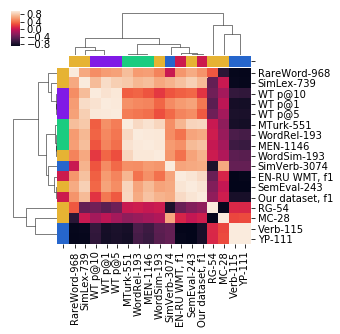

In [240]:
make_clustermap(joint_metrics, out_file_prefix='../../plag/joint_metrics_real_')

In [187]:
# make_clustermap(joint_metrics_order, out_file_prefix='../../plag/joint_metrics_order_')

In [189]:
# make_clustermap(joint_metrics_norm, out_file_prefix='../../plag/joint_metrics_order_')